In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.extensions import HamiltonianGate
from tqdm import tqdm

from circuit_prep import (
    amplitude_damping_channel,
    convert_to_bell_basis,
    compute_estimator,
    hoeffding,
    prepare_bell_state,
    run_circuit,
)

# Setup: define the circuits and execution code

In [2]:
def XX_hamiltonian_gate(circuit, qubit_a: int, qubit_b: int, J: float, time: float):
    x = np.array([[0, 1], [1, 0]])
    H_xx = J * np.kron(x, x)
    gate = HamiltonianGate(H_xx, time, label="$e^{-iH_{XX}t}$")
    circuit.append(gate, [qubit_a, qubit_b])

def YY_hamiltonian_gate(circuit, qubit_a: int, qubit_b: int, J: float, time: float):
    y = np.array([[0, -1j], [1j, 0]])
    H_yy = J * np.kron(y, y)
    gate = HamiltonianGate(H_yy, time, label="$e^{-iH_{YY}t}$")
    circuit.append(gate, [qubit_a, qubit_b])

In [3]:
def circuit_1(ks, ls, J: float, Gamma: float, trotter_steps: int, time: float):
    """This is the circuit that corresponds to e^{Lt} ⊗ e^{Lt}."""
    circuit = QuantumCircuit(8, 4)
    time_step = time / trotter_steps
    step_gamma = 1 - np.exp(-Gamma * time_step)

    prepare_bell_state(circuit, qubit_a=0, qubit_b=4, k=ks[0], l=ls[0])
    prepare_bell_state(circuit, qubit_a=2, qubit_b=6, k=ks[1], l=ls[1])
    circuit.barrier()

    for _ in range(trotter_steps // 2):
        XX_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)
        YY_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)

        amplitude_damping_channel(circuit, qubit_a=0, qubit_b=1, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=2, qubit_b=3, gamma=step_gamma)
        circuit.reset([1, 3])

        amplitude_damping_channel(circuit, qubit_a=0, qubit_b=1, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=2, qubit_b=3, gamma=step_gamma)
        circuit.reset([1, 3])

        YY_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)
        XX_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)

        ######

        XX_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)
        YY_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)

        amplitude_damping_channel(circuit, qubit_a=4, qubit_b=5, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=6, qubit_b=7, gamma=step_gamma)
        circuit.reset([5, 7])

        amplitude_damping_channel(circuit, qubit_a=4, qubit_b=5, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=6, qubit_b=7, gamma=step_gamma)
        circuit.reset([5, 7])

        YY_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)
        XX_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)

        circuit.barrier()

    convert_to_bell_basis(circuit, qubit_a=0, qubit_b=4)
    convert_to_bell_basis(circuit, qubit_a=2, qubit_b=6)
    circuit.barrier()

    circuit.measure([0, 4, 2, 6], [0, 1, 2, 3])

    return circuit

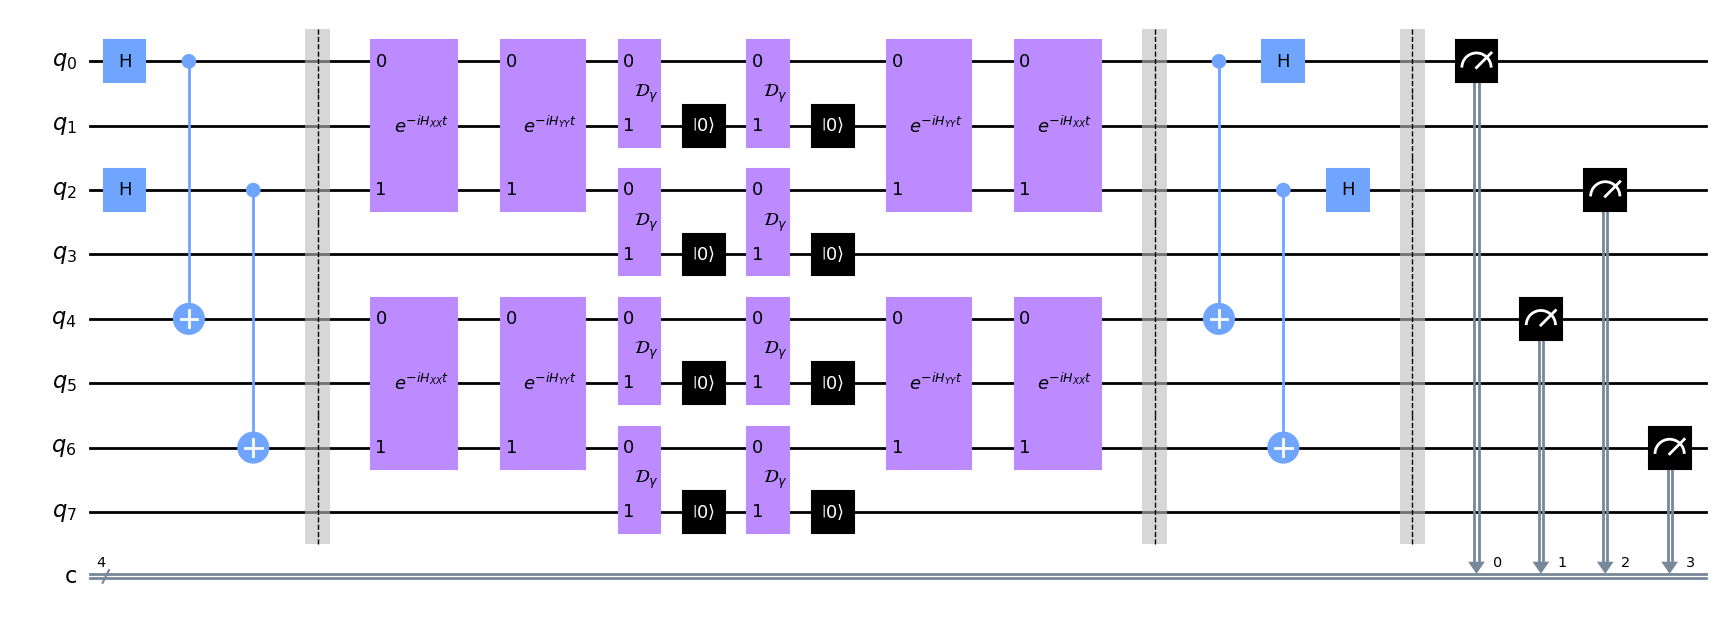

In [4]:
# Visualize an example of the non-symmetrized circuit
ckt = circuit_1(ks=[0,0], ls=[0,0], J=1, Gamma=0.5, trotter_steps=2, time=1)
ckt.draw(output="mpl")

In [5]:
def circuit_2(ks: int, ls: int, J: float, Gamma: float, trotter_steps: int, time: float, symmetry: str):
    """
    This is the 'symmetrized' circuit, implementing (W ∘ e^{Lt}) ⊗ (e^{Lt} ∘ W),
    where {I, W} is our unitary representation of ℤ₂.
    """
    circuit = QuantumCircuit(8, 4)
    time_step = time / trotter_steps
    step_gamma = 1 - np.exp(-Gamma * time_step)

    prepare_bell_state(circuit, qubit_a=0, qubit_b=4, k=ks[0], l=ls[0])
    prepare_bell_state(circuit, qubit_a=2, qubit_b=6, k=ks[1], l=ls[1])
    circuit.barrier()

    if symmetry == "swap":
        circuit.swap(0, 2)
    elif symmetry == "zz":
        circuit.z(0)
        circuit.z(2)
    elif symmetry == "xx":
        circuit.x(0)
        circuit.x(2)
    circuit.barrier()

    for _ in range(trotter_steps // 2):
        XX_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)
        YY_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)

        amplitude_damping_channel(circuit, qubit_a=0, qubit_b=1, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=2, qubit_b=3, gamma=step_gamma)
        circuit.reset([1, 3])

        amplitude_damping_channel(circuit, qubit_a=0, qubit_b=1, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=2, qubit_b=3, gamma=step_gamma)
        circuit.reset([1, 3])

        YY_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)
        XX_hamiltonian_gate(circuit, qubit_a=0, qubit_b=2, J=J, time=time)

        #####

        XX_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)
        YY_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)

        amplitude_damping_channel(circuit, qubit_a=4, qubit_b=5, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=6, qubit_b=7, gamma=step_gamma)
        circuit.reset([5, 7])

        amplitude_damping_channel(circuit, qubit_a=4, qubit_b=5, gamma=step_gamma)
        amplitude_damping_channel(circuit, qubit_a=6, qubit_b=7, gamma=step_gamma)
        circuit.reset([5, 7])

        YY_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)
        XX_hamiltonian_gate(circuit, qubit_a=4, qubit_b=6, J=J, time=time)

        circuit.barrier()


    if symmetry == "swap":
        circuit.swap(4, 6)
    elif symmetry == "zz":
        circuit.z(4)
        circuit.z(6)
    elif symmetry == "xx":
        circuit.x(4)
        circuit.x(6)
    circuit.barrier()

    convert_to_bell_basis(circuit, qubit_a=0, qubit_b=4)
    convert_to_bell_basis(circuit, qubit_a=2, qubit_b=6)
    circuit.barrier()

    circuit.measure([0, 4, 2, 6], [0, 1, 2, 3])

    return circuit


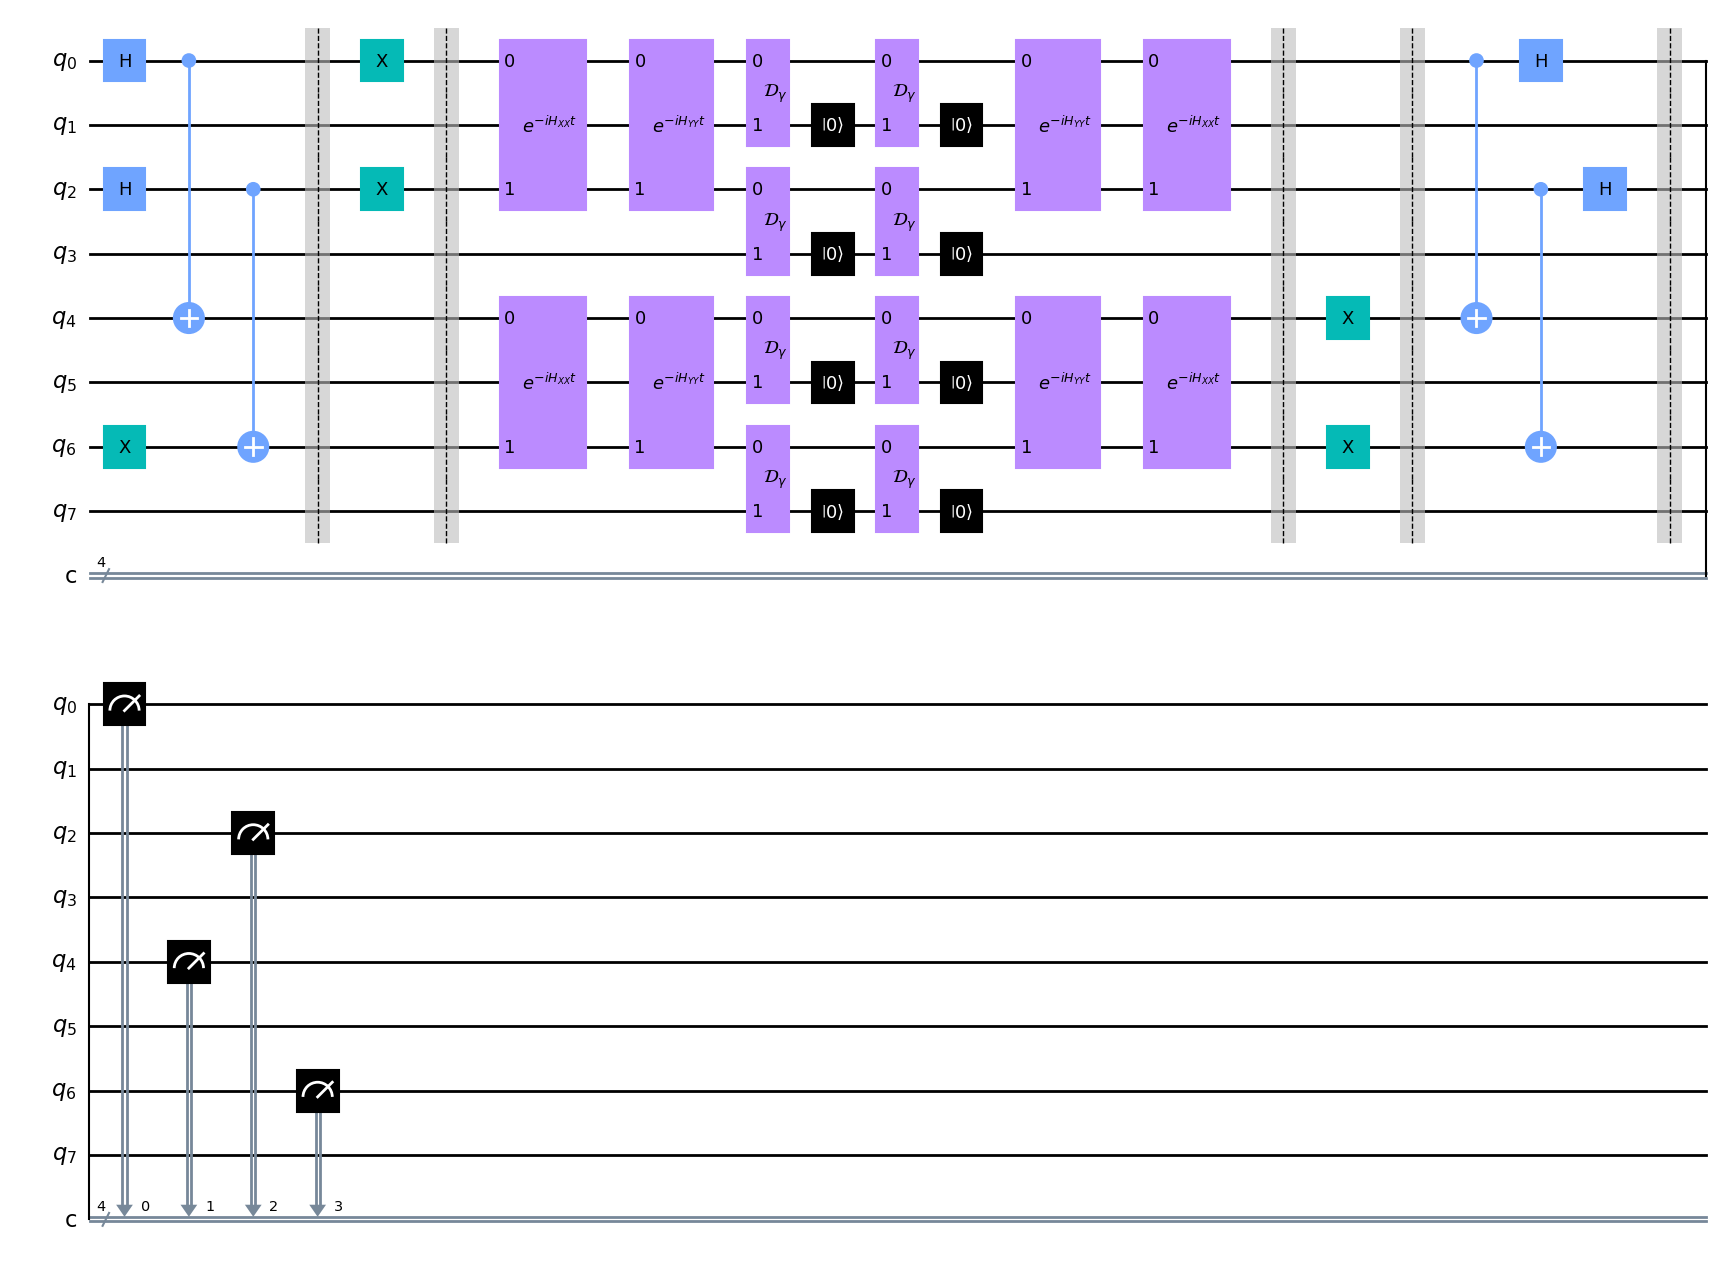

In [6]:
# Visualize an example of the symmetrized circuit
ckt = circuit_2([0,1], [0,0], J=1, Gamma=0.5, trotter_steps=2, time=1, symmetry='xx')
ckt.draw(output="mpl")

In [7]:
def run_full_sim(
    J: float,
    Gamma: float,
    trotter_steps: int,
    shots: int,
    time: float,
    symmetry: str,
    use_noise_model: bool = False
) -> float:
    """Execute the simulation to estimate the asymmetry of the system."""
    c1_results = {}
    c2_results = {}
    for i in range(16):
        k_l = f"{i:04b}"
        k_and_l = [int(char) for char in k_l]
        ks = k_and_l[::2]
        ls = k_and_l[1::2]

        c1 = circuit_1(ks, ls, J=J, Gamma=Gamma, trotter_steps=trotter_steps, time=time)
        c1_results[k_l] = run_circuit(c1, shots // 16, use_noise_model)

        c2 = circuit_2(
            ks, ls, J=J, Gamma=Gamma, trotter_steps=trotter_steps, time=time, symmetry=symmetry
        )
        c2_results[k_l] = run_circuit(c2, shots // 16, use_noise_model)
    
    c1_yt = compute_estimator(c1_results)
    c2_yt = compute_estimator(c2_results)
    return c1_yt - c2_yt

# Measure XX, ZZ, and SWAP asymmetry with noiseless simulator

In [8]:
shots = hoeffding(0.01, 0.01)
Gammas = np.linspace(0, 10, 50)

noiseless_xx_results = []
noiseless_zz_results = []
noiseless_swap_results = []

for Gam in tqdm(Gammas):
    xx_res = run_full_sim(J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="xx")
    noiseless_xx_results.append(xx_res)

    zz_res = run_full_sim(J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="zz")
    noiseless_zz_results.append(zz_res)

    swap_res = run_full_sim(J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="swap")
    noiseless_swap_results.append(swap_res)

100%|██████████| 50/50 [6:28:58<00:00, 466.78s/it]  


In [13]:
def xx_analytical(Gamma, J, t):
    """Analytical form of the XX asymmetry measure."""
    numerator = np.exp(-2 * t * Gamma) * (
        -t**2 * Gamma**2 * np.cos(4 * J)
        - 16 * J**2 * np.cosh(t * Gamma)
        + (16 * J**2 + t**2 * Gamma**2) * np.cosh(2 * t * Gamma)
    )
    denominator = 32 * J**2 + 2 * t**2 * Gamma**2
    return numerator / denominator

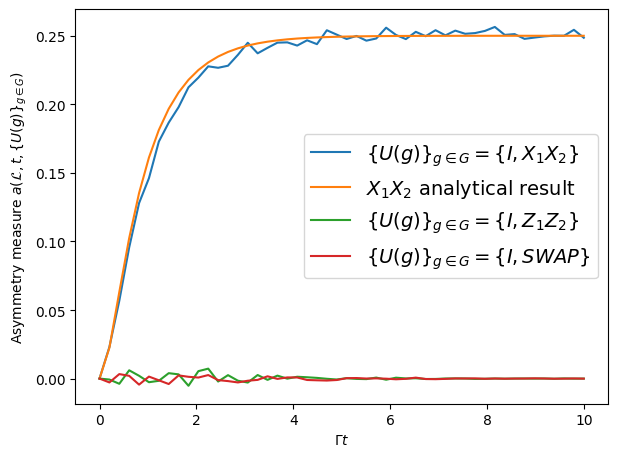

In [10]:
plt.cla()
plt.rcParams.update({'font.size': 14})
plt.plot(Gammas, noiseless_xx_results, label=r'$\{U(g)\}_{g\in G} = \{I, X_1X_2\}$')
plt.plot(Gammas, xx_analytical(Gammas, J=1, t=1), label=r"$X_1X_2$ analytical result")
plt.plot(Gammas, noiseless_zz_results, label=r'$\{U(g)\}_{g\in G} = \{I, Z_1Z_2\}$')
plt.plot(Gammas, noiseless_swap_results, label=r'$\{U(g)\}_{g\in G} = \{I, SWAP\}$')
plt.ylabel(r'Asymmetry measure $a(\mathcal{L}, t, \{U(g)\}_{g\in G})$')
plt.xlabel(r'$\Gamma t$')
plt.legend()
plt.tight_layout()
# plt.savefig('noiseless_spin_chain.pdf', dpi=300, format="pdf")

# Measure XX, ZZ, and SWAP asymmetry with noisy simulator

In [11]:
shots = hoeffding(0.01, 0.01)
Gammas = np.linspace(0, 10, 50)

noisy_xx_results = []
noisy_zz_results = []
noisy_swap_results = []

for Gam in tqdm(Gammas):
    xx_res = run_full_sim(
        J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="xx", use_noise_model=True
    )
    noisy_xx_results.append(xx_res)

    zz_res = run_full_sim(
        J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="zz", use_noise_model=True
    )
    noisy_zz_results.append(zz_res)

    swap_res = run_full_sim(
        J=1, Gamma=Gam, trotter_steps=20, shots=shots, time=1, symmetry="swap", use_noise_model=True
    )
    noisy_swap_results.append(swap_res)

100%|██████████| 50/50 [31:22<00:00, 37.65s/it]


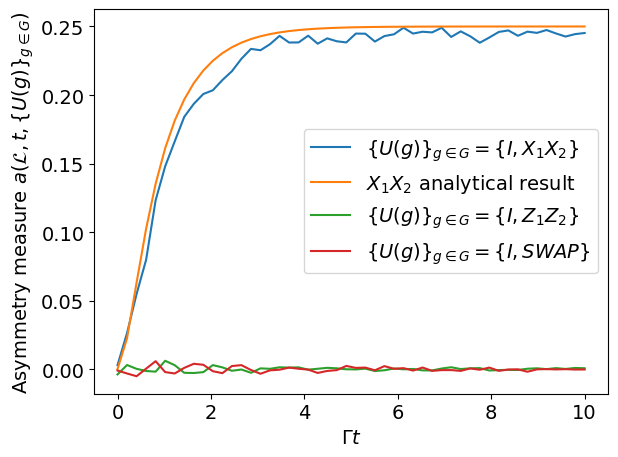

In [14]:
plt.cla()
plt.rcParams.update({'font.size': 14})
plt.plot(Gammas, noisy_xx_results, label=r'$\{U(g)\}_{g\in G} = \{I, X_1X_2\}$')
plt.plot(Gammas, xx_analytical(Gammas, J=1, t=1), label=r"$X_1X_2$ analytical result")
plt.plot(Gammas, noisy_zz_results, label=r'$\{U(g)\}_{g\in G} = \{I, Z_1Z_2\}$')
plt.plot(Gammas, noisy_swap_results, label=r'$\{U(g)\}_{g\in G} = \{I, SWAP\}$')
plt.ylabel(r'Asymmetry measure $a(\mathcal{L}, t, \{U(g)\}_{g\in G})$')
plt.xlabel(r'$\Gamma t$')
plt.legend()
plt.tight_layout()
# plt.savefig('noisy_spin_chain.pdf', dpi=300, format="pdf")